# Data Download & Unzip

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive/Speech_Recognition

 Group_projectv0.ipynb	'Spotify Music Feature.csv'   大纲.gdoc


In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"username","key":"key"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle competitions download -c tensorflow-speech-recognition-challenge

100% 3.49G/3.50G [00:23<00:00, 189MB/s]
100% 3.50G/3.50G [00:23<00:00, 162MB/s]


In [ ]:
!pip install pyunpack 
!pip install patool

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 2.1 MB/s 


In [ ]:
!unzip /content/tensorflow-speech-recognition-challenge.zip -d /content/drive/MyDrive/Speech_Recognition/Unzip

Archive:  /content/tensorflow-speech-recognition-challenge.zip
  inflating: /content/drive/MyDrive/Speech_Recognition/Unzip/link_to_gcp_credits_form.txt  
  inflating: /content/drive/MyDrive/Speech_Recognition/Unzip/sample_submission.7z  
  inflating: /content/drive/MyDrive/Speech_Recognition/Unzip/test.7z  
  inflating: /content/drive/MyDrive/Speech_Recognition/Unzip/train.7z  


In [ ]:
from pyunpack import Archive

#Archive("/content/drive/MyDrive/Speech_Recognition/Unzip/train.7z").extractall("/content/drive/MyDrive/Speech_Recognition/Unzip/data")
#Archive("/content/drive/MyDrive/Speech_Recognition/Unzip/test.7z").extractall("/content/drive/MyDrive/Speech_Recognition/Unzip/data")

# Data Pre-Processing

In [ ]:
import librosa
import numpy as np
import os
import csv
from scipy.io import wavfile
import matplotlib.pyplot as plt

train_dir = "/content/drive/MyDrive/Speech_Recognition/Unzip/data/train/audio/" 

In [ ]:
classes = os.listdir("/content/drive/MyDrive/Speech_Recognition/Unzip/data/train/audio/")
classes.remove("_background_noise_")
classes

['bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'four',
 'go',
 'happy',
 'house',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'wow',
 'yes',
 'zero']

In [ ]:
!mv /content/drive/MyDrive/Speech_Recognition/Unzip/data/train/audio/_background_noise_ /content/drive/MyDrive/Speech_Recognition/Unzip/data/train
!ls /content/drive/MyDrive/Speech_Recognition/Unzip/data/train/audio/

bed   dog    five  happy  marvin  off  right   six    tree  wow
bird  down   four  house  nine	  on   seven   stop   two   yes
cat   eight  go    left   no	  one  sheila  three  up    zero


In [ ]:
def split_arr(arr):
    """
    split an array into chunks of length 16000
    Returns:
        list of arrays
    """
    return np.split(arr, np.arange(16000, len(arr), 16000))

In [ ]:
import soundfile as sf

def create_silence():
    """
    reads wav files in background noises folder, 
    splits them and saves to silence folder in train_dir
    """
    for file in os.listdir("/content/drive/MyDrive/Speech_Recognition/Unzip/data/train/_background_noise_/"):
        if ".wav" in file:
            sig, sr = librosa.load("/content/drive/MyDrive/Speech_Recognition/Unzip/data/train/_background_noise_/"+file, sr = 16000) 
            sig_arr = split_arr(sig)
            if not os.path.exists(train_dir+"silence/"):
                os.makedirs(train_dir+"silence/")
            for ind, arr in enumerate(sig_arr):
                file_name = "frag%d" %ind + "_%s" %file # example: frag0_running_tap.wav
                sf.write(train_dir+"silence/"+file_name, arr, 16000)

In [ ]:
create_silence()

In [ ]:
folders = os.listdir(train_dir)
# put folders in same order as in the classes list, used when making sets
all_classes = [x for x in classes]
for ind, cl in enumerate(folders):
    if cl not in classes:
        all_classes.append(cl)
print(all_classes)

['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero', 'silence']


In [ ]:
with open("/content/drive/MyDrive/Speech_Recognition/Unzip/data/train/validation_list.txt") as val_list:
    validation_list = [row[0] for row in csv.reader(val_list)]
assert len(validation_list) == 6798, "Validation files not loaded"

In [ ]:
with open("/content/drive/MyDrive/Speech_Recognition/Unzip/data/train/testing_list.txt") as val_list:
    testing_list = [row[0] for row in csv.reader(val_list)]
assert len(testing_list) == 6835, "testing files not loaded"

In [ ]:
#validation_list.extend(testing_list)

In [ ]:
# add silence files to validation_list
for i, file in enumerate(os.listdir(train_dir+"silence/")):
    if i%10 == 0:
        validation_list.append("silence/"+file)

### Data Processing

In [ ]:
labels=["eight", "five", "four",
        "nine", "one", "seven",
        "six", "tree", "two", "zero"]
duration_of_recordings=[]
x_list = []
y_list = []
for label in labels:
    waves = [f for f in os.listdir(train_dir + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_dir + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
        x_list.append(samples)
        y_list.append(label)

In [ ]:
from scipy import signal
import random

def f_low(y,sr):
    b,a = signal.butter(35, 3000/(sr/2), btype='lowpass')
    yf = signal.lfilter(b,a,y)
    return yf

In [ ]:
a_f = f_low(x_list[1270], 16000)

In [ ]:
for i in range(len(x_list)):
  x_f = f_low(x_list[i]*1.0, 16000)
  x_list[i] = x_f

In [ ]:
from IPython.display import Audio, IFrame, display

display(Audio(x_list[1270],rate=16000))
display(Audio(a_f,rate=16000))

In [ ]:
for i in range(len(duration_of_recordings)):
  if len(x_list[i]) != sample_rate:
    zeros = np.zeros(sample_rate - len(x_list[i]))
    new_x = np.concatenate((x_list[i], zeros), axis=None)
    x_list[i] = new_x
    duration_of_recordings[i] = float(len(x_list[i])/sample_rate)

In [ ]:
import pandas as pd
from keras.utils import np_utils
y_df = pd.DataFrame(y_list)
y_codes, y_uniques = pd.factorize(y_df.iloc[:,0])
y_codes = np_utils.to_categorical(y_codes, num_classes=len(labels))

In [ ]:
mel_list = []
for i in range(len(x_list)):
  S = librosa.feature.melspectrogram(y = x_list[i]*1.0, sr=sample_rate, n_mels = 75, hop_length = 214)
  mel_list.append(S)

In [ ]:
mel_list_db = []
for i in range(len(mel_list)):
  mel_list_db.append(librosa.power_to_db(mel_list[i]))

In [ ]:
from sklearn.preprocessing import normalize

for i in range(len(mel_list_db)):
  mel_list_db[i] = normalize(mel_list_db[i], axis=1, norm='l1')

In [ ]:
mel_list_db[0].shape

(75, 75)

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

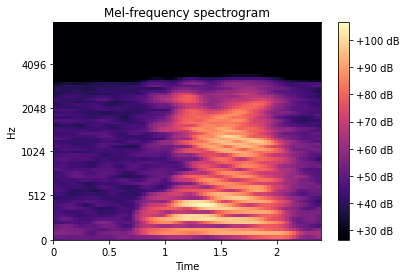

In [ ]:
import librosa.display
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.power_to_db(mel_list[23000]), x_axis='time',
                         y_axis='mel', sr=sample_rate,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [ ]:
sound = librosa.feature.inverse.mel_to_stft(mel_list[23000])
sound = librosa.griffinlim(sound)

In [ ]:
from IPython.display import Audio
Audio(data=sound, rate=16000)

In [ ]:
mfcc_list = []
for i in range(len(mel_list)):
  mfcc = librosa.feature.mfcc(S=mel_list[i], n_mfcc = 75)
  mfcc_list.append(mfcc)

In [ ]:
y_list[23000]

'zero'

# Prediction Using Mel-Spectrogram

In [ ]:
from sklearn.model_selection import train_test_split

mel_train, mel_val, mel_y_train, mel_y_val = train_test_split(mel_list_db, np.array(y_codes), stratify = y_codes, test_size=0.1, random_state=12, shuffle = True)

In [ ]:
mel_train = np.array(mel_train)
mel_train = mel_train.reshape(np.array(mel_train).shape[0], np.array(mel_train).shape[1], np.array(mel_train).shape[2], 1)
mel_val = np.array(mel_val)
mel_val = mel_val.reshape(np.array(mel_val).shape[0], np.array(mel_val).shape[1], np.array(mel_val).shape[2], 1)

In [ ]:
mel_y_train.shape

(20738, 10)

In [ ]:
np.array(mel_train).shape

(20738, 75, 75, 1)

In [ ]:
mel_y_train = mel_y_train.astype(int)
mel_y_val = mel_y_val.astype(int)

In [ ]:
import tensorflow as tf
from keras.optimizers import SGD
from keras.constraints import maxnorm
from keras import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten, Conv2D, Input, MaxPooling2D
from keras.layers import BatchNormalization
model = Sequential()
model.add(Conv2D(32, kernel_size=(4, 4), activation='relu', input_shape=(75,75,1)))
model.add(BatchNormalization())

model.add(Conv2D(48, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(120, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [ ]:
model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(lr=0.0001),
        metrics=["accuracy"])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
history = model.fit(mel_train, mel_y_train, batch_size=64, epochs=30, validation_data = (mel_val, mel_y_val))

Epoch 1/30
325/325 [==============================] - 23s 67ms/step - loss: 2.2529 - accuracy: 0.3129 - val_loss: 2.3524 - val_accuracy: 0.1028
Epoch 2/30
325/325 [==============================] - 22s 69ms/step - loss: 1.4146 - accuracy: 0.5377 - val_loss: 1.6983 - val_accuracy: 0.4473
Epoch 3/30
325/325 [==============================] - 22s 69ms/step - loss: 1.2786 - accuracy: 0.5774 - val_loss: 1.0358 - val_accuracy: 0.6729
Epoch 4/30
325/325 [==============================] - 22s 69ms/step - loss: 1.0279 - accuracy: 0.6617 - val_loss: 0.6879 - val_accuracy: 0.8030
Epoch 5/30
325/325 [==============================] - 22s 68ms/step - loss: 0.8544 - accuracy: 0.7240 - val_loss: 1.6317 - val_accuracy: 0.4746
Epoch 6/30
325/325 [==============================] - 22s 68ms/step - loss: 0.7302 - accuracy: 0.7682 - val_loss: 0.9554 - val_accuracy: 0.7054
Epoch 7/30
325/325 [==============================] - 22s 68ms/step - loss: 0.6575 - accuracy: 0.7921 - val_loss: 0.5558 - val_accuracy:

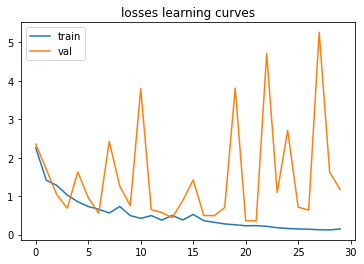

In [ ]:
plt.plot(history.history['loss'], label='train')  # losses learning curve of training set.
plt.plot(history.history['val_loss'], label='val') # losses learning curve of validation set.
plt.legend()
plt.title("losses learning curves")
plt.show()

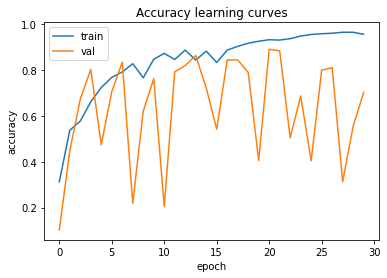

In [ ]:
plt.plot(history.history['accuracy'])      # Accuracy learning curve of training set.
plt.plot(history.history['val_accuracy'])  # Accuracy learning curve of validation set.
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title("Accuracy learning curves")
plt.show()

In [ ]:
from keras.applications import ResNet50

model_resnet = ResNet50(weights = "imagenet", include_top = False, input_shape = (96,96,3))

new_model = Sequential()
new_model.add(model_resnet)
new_model.add(Flatten())
new_model.add(Dense(64, activation = "relu"))
new_model.add(Dense(10, activation = "softmax"))
new_model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
mel_train = mel_train.reshape(mel_train.shape[0], mel_train.shape[1], mel_train.shape[2])
res_train = []
for i in range(len(mel_train)):
  res_train.append(np.dstack((mel_train[i], mel_train[i], mel_train[i])))

In [ ]:
for i in range(len(res_train)):
  res_train[i] = np.pad(res_train[i], ((11,10), (11,10), (0, 0)), 'constant')

In [ ]:
res_val = []
for i in range(len(mel_val)):
  res_val.append(np.dstack((mel_val[i], mel_val[i], mel_val[i])))

In [ ]:
for i in range(len(res_val)):
  res_val[i] = np.pad(res_val[i], ((11,10), (11,10), (0, 0)), 'constant')

In [ ]:
res_train = np.array(res_train)
res_val = np.array(res_val)

In [ ]:
es1 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc1 = ModelCheckpoint('best_model_resnet.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
tf.config.run_functions_eagerly(True)
history1 = new_model.fit(res_train, mel_y_train, batch_size=64, epochs=30, validation_data = (res_val, mel_y_val))

/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/30
325/325 [==============================] - 67s 204ms/step - loss: 0.8496 - accuracy: 0.7411 - val_loss: 2.3032 - val_accuracy: 0.1028
Epoch 2/30
325/325 [==============================] - 66s 202ms/step - loss: 0.2728 - accuracy: 0.9197 - val_loss: 2.3042 - val_accuracy: 0.1028
Epoch 3/30
325/325 [==============================] - 65s 201ms/step - loss: 0.3425 - accuracy: 0.8999 - val_loss: 2.3045 - val_accuracy: 0.1028
Epoch 4/30
325/325 [==============================] - 66s 202ms/step - loss: 0.3203 - accuracy: 0.9065 - val_loss: 2.3169 - val_accuracy: 0.1028
Epoch 5/30
325/325 [==============================] - 66s 202ms/step - loss: 0.1692 - accuracy: 0.9488 - val_loss: 1.7102 - val_accuracy: 0.5150
Epoch 6/30
325/325 [==============================] - 65s 201ms/step - loss: 0.2115 - accuracy: 0.9368 - val_loss: 1.5684 - val_accuracy: 0.6000
Epoch 7/30
325/325 [==============================] - 65s 202ms/step - loss: 0.1063 - accuracy: 0.9650 - val_loss: 0.2968 - val_ac

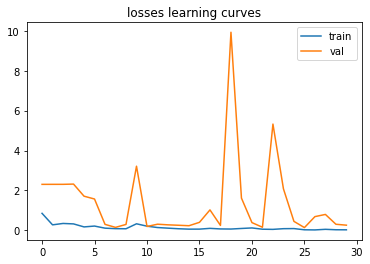

In [ ]:
plt.plot(history1.history['loss'], label='train')  # losses learning curve of training set.
plt.plot(history1.history['val_loss'], label='val') # losses learning curve of validation set.
plt.legend()
plt.title("losses learning curves")
plt.show()

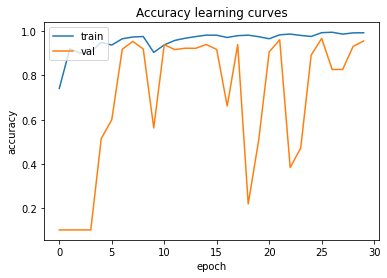

In [ ]:
plt.plot(history1.history['accuracy'])      # Accuracy learning curve of training set.
plt.plot(history1.history['val_accuracy'])  # Accuracy learning curve of validation set.
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title("Accuracy learning curves")
plt.show()

In [ ]:
res_val = []
model_resnet = 0 
new_model = 0 

In [ ]:
inc_train = []
for i in range(len(mel_train)):
  inc_train.append(np.dstack((mel_train[i], mel_train[i], mel_train[i])))
inc_val = [] 
for i in range(len(mel_val)):
  inc_val.append(np.dstack((mel_val[i],mel_val[i],mel_val[i])))

In [ ]:
inc_train = np.array(inc_train)
inc_val = np.array(inc_val)

In [ ]:
inc_train.shape

(20738, 75, 75, 3)

In [ ]:
inc_val.shape

(2305, 75, 75, 3)

In [ ]:
import tensorflow as tf
from keras.applications.inception_v3 import InceptionV3

model = InceptionV3(weights = "imagenet", include_top=False, input_shape = (75, 75, 3))

new_model = Sequential()
new_model.add(model)
new_model.add(Flatten())
new_model.add(Dense(64, activation = "relu"))
new_model.add(Dense(10, activation = "softmax"))
new_model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

87910968/87910968 [==============================] - 4s 0us/step


In [ ]:
es2 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc2 = ModelCheckpoint('best_model_inc.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
tf.config.run_functions_eagerly(True)
history_inc = new_model.fit(inc_train, mel_y_train, epochs = 30, batch_size = 64, validation_data = (inc_val, mel_y_val))

/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/30
325/325 [==============================] - 90s 251ms/step - loss: 0.6289 - accuracy: 0.7987 - val_loss: 2.2619 - val_accuracy: 0.3896
Epoch 2/30
325/325 [==============================] - 80s 246ms/step - loss: 0.2194 - accuracy: 0.9399 - val_loss: 0.4958 - val_accuracy: 0.8386
Epoch 3/30
325/325 [==============================] - 81s 248ms/step - loss: 0.2268 - accuracy: 0.9348 - val_loss: 0.7318 - val_accuracy: 0.8954
Epoch 4/30
325/325 [==============================] - 79s 244ms/step - loss: 0.1391 - accuracy: 0.9579 - val_loss: 0.8331 - val_accuracy: 0.7887
Epoch 5/30
325/325 [==============================] - 80s 246ms/step - loss: 0.2859 - accuracy: 0.9119 - val_loss: 0.2253 - val_accuracy: 0.9289
Epoch 6/30
325/325 [==============================] - 79s 244ms/step - loss: 0.1585 - accuracy: 0.9525 - val_loss: 0.3782 - val_accuracy: 0.8954
Epoch 7/30
325/325 [==============================] - 79s 244ms/step - loss: 0.1848 - accuracy: 0.9446 - val_loss: 0.1741 - val_ac

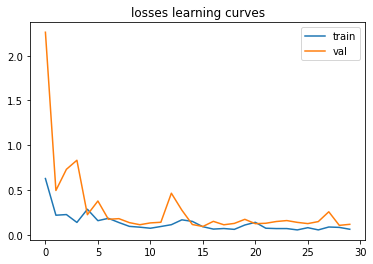

In [ ]:
plt.plot(history_inc.history['loss'], label='train')  # losses learning curve of training set.
plt.plot(history_inc.history['val_loss'], label='val') # losses learning curve of validation set.
plt.legend()
plt.title("losses learning curves")
plt.show()

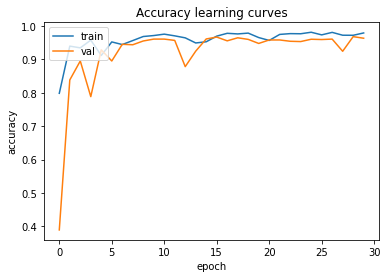

In [ ]:
plt.plot(history_inc.history['accuracy'])      # Accuracy learning curve of training set.
plt.plot(history_inc.history['val_accuracy'])  # Accuracy learning curve of validation set.
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title("Accuracy learning curves")
plt.show()

# Prediction using MFCC 

In [ ]:
mfcc_list = np.array(mfcc_list)

In [ ]:
mfcc_train, mfcc_val, mfcc_y_train, mfcc_y_val = train_test_split(mfcc_list, np.array(y_codes), stratify = y_codes, test_size=0.1, random_state=12, shuffle = True)

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(4, 4), activation='relu', input_shape=(75,75,1)))
model.add(BatchNormalization())

model.add(Conv2D(48, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(120, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [ ]:
model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(lr=0.0001),
        metrics=["accuracy"])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
es3 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc3 = ModelCheckpoint('best_model_res_mfcc.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
history_mfcc = model.fit(mfcc_train, mfcc_y_train, batch_size=64, epochs=150, validation_data = (mfcc_val,mfcc_y_val))

Epoch 1/150


/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


325/325 [==============================] - 34s 101ms/step - loss: 2.9196 - accuracy: 0.1561 - val_loss: 2.1450 - val_accuracy: 0.2182
Epoch 2/150
325/325 [==============================] - 33s 102ms/step - loss: 2.4114 - accuracy: 0.2508 - val_loss: 2.1816 - val_accuracy: 0.2430
Epoch 3/150
325/325 [==============================] - 33s 102ms/step - loss: 2.0973 - accuracy: 0.3211 - val_loss: 2.2413 - val_accuracy: 0.2625
Epoch 4/150
325/325 [==============================] - 33s 101ms/step - loss: 1.8521 - accuracy: 0.3753 - val_loss: 2.3088 - val_accuracy: 0.2698
Epoch 5/150
325/325 [==============================] - 33s 102ms/step - loss: 1.6638 - accuracy: 0.4328 - val_loss: 2.3767 - val_accuracy: 0.2672
Epoch 6/150
325/325 [==============================] - 33s 101ms/step - loss: 1.6234 - accuracy: 0.4456 - val_loss: 2.2906 - val_accuracy: 0.2998
Epoch 7/150
325/325 [==============================] - 33s 102ms/step - loss: 1.4558 - accuracy: 0.4970 - val_loss: 2.3143 - val_accurac

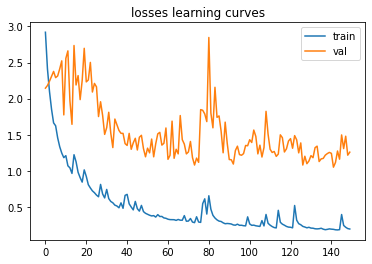

In [ ]:
plt.plot(history_mfcc.history['loss'], label='train')  # losses learning curve of training set.
plt.plot(history_mfcc.history['val_loss'], label='val') # losses learning curve of validation set.
plt.legend()
plt.title("losses learning curves")
plt.show()

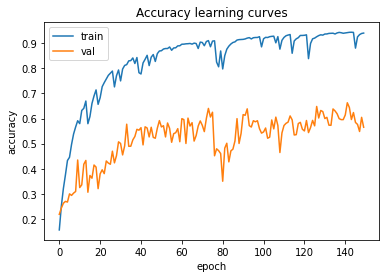

In [ ]:
plt.plot(history_mfcc.history['accuracy'])      # Accuracy learning curve of training set.
plt.plot(history_mfcc.history['val_accuracy'])  # Accuracy learning curve of validation set.
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title("Accuracy learning curves")
plt.show()

In [ ]:
wjb_demo, sample_rate = librosa.load("/content/drive/MyDrive/Speech_Recognition/Test-Jiabao-One_3.wav", sr=16000)
zeros = np.zeros(sample_rate - len(wjb_demo))
wjb_demo = np.concatenate((wjb_demo, zeros), axis=None)

In [ ]:
new_demo_S = librosa.feature.melspectrogram(wjb_demo, sr=16000, n_mels = 75, hop_length = 214)
new_demo_S_db = librosa.power_to_db(new_demo_S)
mfcc_demo = librosa.feature.mfcc(S=new_demo_S, n_mfcc = 75)

In [ ]:
inc_demo = np.dstack((new_demo_S_db, new_demo_S_db, new_demo_S_db))
inc_demo = inc_demo.reshape(1,75,75,3)

In [ ]:
new_model.predict(inc_demo)

1/1 [==============================] - 0s 105ms/step


/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)